In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
import math
import gc
import random
from tensorboard.plugins.hparams import api as hp

RESHAPED = 1
NB_CLASSES = 1
DROPOUT = 0.3
N_HIDDEN = 512
BATCH_SIZE = 15
EPOCHS = 50
VERBOSE = 1
VALIDATION_SPLIT = 0.25
TOTAL_DATA_POINTS = 10000
EXPONENT = 2

counts = [1000., 10.]
# Probability of success.
probs = [.99]

#Want to make the schuffle happen the same way every time
tf.random.set_seed(5)
tf.random.shuffle(tf.range(5))


def get_dataset():
    rng = tf.random.Generator.from_seed(seed=234)
    randomNumbers = rng.truncated_normal(shape=[TOTAL_DATA_POINTS], mean=0.5, stddev=.05)
    return randomNumbers

random_dataset = get_dataset()
            
def convert_to_train_test_data(dataset, test_percent = 0.15):
    point_number = []
    total_independent = []
    total_dependent = []
    count = 1
    for i in range(1, TOTAL_DATA_POINTS):
        point_number.append(i)
    random.shuffle(point_number)
    
    for i in point_number:
        if (int(i/200) == 200):
            total_dependent.append(-1000) 
        else:
            total_dependent.append((i ** EXPONENT) * dataset[i])
        total_independent.append(i ** EXPONENT)
            
    testRecordCount = int(round(test_percent*len(total_independent)))
    return point_number[testRecordCount:], total_independent[testRecordCount:], total_dependent[testRecordCount:], point_number[:testRecordCount], total_independent[:testRecordCount], total_dependent[:testRecordCount]
    
x_train, x_train_modified, y_train, x_test, x_test_modified, y_test = convert_to_train_test_data(random_dataset, test_percent=0.15)


def createModel(optimizer_name, learningRate):
    tf.random.set_seed(1234)
    if optimizer_name == "sgd":
        opt = tf.keras.optimizers.SGD(learning_rate=learningRate)
    elif optimizer_name == "adagrad":
        opt = tf.keras.optimizers.Adagrad(learning_rate=learningRate)
    elif optimizer_name == "adadelta":
        opt = tf.keras.optimizers.Adadelta(learning_rate=learningRate)
    elif optimizer_name == "rmsprop":
        opt = tf.keras.optimizers.RMSprop(learning_rate=learningRate)
    elif optimizer_name == "adam":
        opt = tf.keras.optimizers.Adam(learning_rate=learningRate)
    else:
        raise ValueError("unexpected optimizer name: %r" % (optimizer_name,))

    model = tf.keras.models.Sequential()
    model.add(keras.layers.Dense(N_HIDDEN, input_shape=(RESHAPED,), name='input_dense_layer', activation='relu'))
    model.add(keras.layers.Dropout(DROPOUT))
    model.add(keras.layers.Dense(N_HIDDEN, name='hidden_dense_layer', activation='relu'))
    model.add(keras.layers.Dropout(DROPOUT))
    model.add(keras.layers.Dense(NB_CLASSES, name='output_dense_layer'))
    model.compile(optimizer=opt, loss='MAE', metrics=['accuracy'])
    
    return model

def showPrediction(model, x_train, x_train_modified, y_train, x_test, x_test_modified, y_test, optimizer, learning_rate):
    NEXT_POINT = TOTAL_DATA_POINTS + 1
    FUTURE_INDEPENDANT = [NEXT_POINT ** EXPONENT]
    FUTURE_DEPENDANT = []

    PREDICTED_INDEPENDANT = []
    PREDICTED_DEPENDANT = []

    pred_traning = model.predict(np.array(x_train_modified))

    count = 0
    for deaths in pred_traning:
        PREDICTED_INDEPENDANT.append(x_train[count])
        PREDICTED_DEPENDANT.append(deaths)
        count += 1

    pred_validation = model.predict(np.array(x_test_modified))

    count = 0
    for deaths in pred_validation:
        PREDICTED_INDEPENDANT.append(x_test[count])
        PREDICTED_DEPENDANT.append(deaths)
        count += 1

    pred_dependant = model.predict(FUTURE_INDEPENDANT)

    for item in pred_dependant:
        FUTURE_DEPENDANT.append(item)
    
    fig, ax = plt.subplots()  # Create a figure and an axes.
    ax.plot(x_train, y_train, label='training data', linewidth=0, marker='.')
    ax.plot(x_test, y_test, label='test data', linewidth=0, marker='.')
    ax.plot(PREDICTED_INDEPENDANT, PREDICTED_DEPENDANT, label='prediction values', linewidth=0, marker='.')
    ax.plot([NEXT_POINT], FUTURE_DEPENDANT, label='future prediction', linewidth=0, marker='.')
    ax.set_xlabel('independent')  # Add an x-label to the axes.
    ax.set_ylabel('dependant')  # Add a y-label to the axes.
    ax.set_title(optimizer + " " +  str(learning_rate))  # Add a title to the axes.
    ax.legend() 
    
print('done')

done


In [2]:
#Setup hyper parameters
HP_OPTIMIZERNAME = hp.HParam('optimizername', hp.Discrete(['sgd', 'adagrad', 'adadelta', 'rmsprop', 'adam']))
HP_LEARNINGRATE = hp.HParam('learningRate', hp.Discrete([1.0, 0.1, 0.01, 0.001, 0.0001]))

METRIC_ACCURACY = 'accuracy'
METRIC_LOSS = 'loss'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_OPTIMIZERNAME, HP_LEARNINGRATE],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy'),
            hp.Metric(METRIC_LOSS, display_name='Loss')],
    )
    
def train_test_model(hparams):
    tf.random.set_seed(1234)
    np.random.seed(0)
    
    model = createModel(hparams[HP_OPTIMIZERNAME], hparams[HP_LEARNINGRATE])


    history = model.fit(np.array(x_train_modified), np.array(y_train), batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

    test_loss, test_acc = model.evaluate(np.array(x_test_modified), np.array(y_test))
    
    showPrediction(model, x_train, x_train_modified, y_train, x_test, x_test_modified, y_test, hparams[HP_OPTIMIZERNAME], hparams[HP_LEARNINGRATE])    

    del model
    return test_loss, test_acc

def run(run_dir, hparams):
    file_writer = tf.summary.create_file_writer(run_dir)
    with file_writer.as_default():
        hp.hparams(hparams)  # record the values used in this trial
        loss, accuracy = train_test_model(hparams)
        tf.summary.scalar(METRIC_LOSS, loss, step=1)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)
    tf.summary.flush(writer=file_writer)
    tf.keras.backend.clear_session()
    del file_writer
    
    gc.collect()
        
print('complete')

complete


--- Starting trial: run-0
{'optimizername': 'adadelta', 'learningRate': 0.0001}
Epoch 1/50
425/425 [==============================] - 2s 5ms/step - loss: 16340649.0000 - accuracy: 0.0000e+00 - val_loss: 17010870.0000 - val_accuracy: 0.0000e+00
Epoch 2/50
425/425 [==============================] - 2s 4ms/step - loss: 15911798.0000 - accuracy: 0.0000e+00 - val_loss: 16563810.0000 - val_accuracy: 0.0000e+00
Epoch 3/50
425/425 [==============================] - 2s 4ms/step - loss: 15565674.0000 - accuracy: 0.0000e+00 - val_loss: 16110306.0000 - val_accuracy: 0.0000e+00
Epoch 4/50
425/425 [==============================] - 2s 4ms/step - loss: 15127430.0000 - accuracy: 0.0000e+00 - val_loss: 15650644.0000 - val_accuracy: 0.0000e+00
Epoch 5/50
425/425 [==============================] - 2s 5ms/step - loss: 14700158.0000 - accuracy: 0.0000e+00 - val_loss: 15185559.0000 - val_accuracy: 0.0000e+00
Epoch 6/50
425/425 [==============================] - 2s 5ms/step - loss: 14302037.0000 - accuracy: 

47/47 [==============================] - 0s 2ms/step - loss: 1271169.6250 - accuracy: 0.0000e+00
--- Starting trial: run-1
{'optimizername': 'adadelta', 'learningRate': 0.001}
Epoch 1/50
425/425 [==============================] - 2s 5ms/step - loss: 14559925.0000 - accuracy: 0.0000e+00 - val_loss: 13045883.0000 - val_accuracy: 0.0000e+00
Epoch 2/50
425/425 [==============================] - 2s 5ms/step - loss: 10363279.0000 - accuracy: 0.0000e+00 - val_loss: 8200558.0000 - val_accuracy: 0.0000e+00
Epoch 3/50
425/425 [==============================] - 2s 5ms/step - loss: 5954659.5000 - accuracy: 0.0000e+00 - val_loss: 3223339.2500 - val_accuracy: 0.0000e+00
Epoch 4/50
425/425 [==============================] - 2s 5ms/step - loss: 2577624.5000 - accuracy: 0.0000e+00 - val_loss: 1268104.7500 - val_accuracy: 0.0000e+00
Epoch 5/50
425/425 [==============================] - 2s 5ms/step - loss: 1916488.0000 - accuracy: 0.0000e+00 - val_loss: 1279389.8750 - val_accuracy: 0.0000e+00
Epoch 6/50


425/425 [==============================] - 2s 6ms/step - loss: 1722480.2500 - accuracy: 0.0000e+00 - val_loss: 1246418.8750 - val_accuracy: 0.0000e+00
Epoch 50/50
47/47 [==============================] - 0s 2ms/step - loss: 1244214.7500 - accuracy: 0.0000e+00
--- Starting trial: run-2
{'optimizername': 'adadelta', 'learningRate': 0.01}
Epoch 1/50
425/425 [==============================] - 3s 7ms/step - loss: 4455661.0000 - accuracy: 0.0000e+00 - val_loss: 1340470.0000 - val_accuracy: 0.0000e+00
Epoch 2/50
425/425 [==============================] - 3s 6ms/step - loss: 1883519.7500 - accuracy: 0.0000e+00 - val_loss: 1265392.8750 - val_accuracy: 0.0000e+00
Epoch 3/50
425/425 [==============================] - 3s 6ms/step - loss: 1854542.3750 - accuracy: 0.0000e+00 - val_loss: 1324466.3750 - val_accuracy: 0.0000e+00
Epoch 4/50
425/425 [==============================] - 3s 6ms/step - loss: 1809942.8750 - accuracy: 0.0000e+00 - val_loss: 1249586.1250 - val_accuracy: 0.0000e+00
Epoch 5/50
425

425/425 [==============================] - 2s 4ms/step - loss: 1418619.2500 - accuracy: 0.0000e+00 - val_loss: 2208836.7500 - val_accuracy: 0.0000e+00
Epoch 49/50
425/425 [==============================] - 2s 5ms/step - loss: 1420471.7500 - accuracy: 0.0000e+00 - val_loss: 1917615.1250 - val_accuracy: 0.0000e+00
Epoch 50/50
47/47 [==============================] - 0s 2ms/step - loss: 2188244.5000 - accuracy: 0.0000e+00
--- Starting trial: run-3
{'optimizername': 'adadelta', 'learningRate': 0.1}
Epoch 1/50
425/425 [==============================] - 2s 5ms/step - loss: 2075255.8750 - accuracy: 0.0000e+00 - val_loss: 1259662.1250 - val_accuracy: 0.0000e+00
Epoch 2/50
425/425 [==============================] - 2s 5ms/step - loss: 1642111.1250 - accuracy: 0.0000e+00 - val_loss: 1248888.8750 - val_accuracy: 0.0000e+00
Epoch 3/50
425/425 [==============================] - 2s 4ms/step - loss: 1614668.3750 - accuracy: 0.0000e+00 - val_loss: 1384126.3750 - val_accuracy: 0.0000e+00
Epoch 4/50
425

425/425 [==============================] - 3s 6ms/step - loss: 1455828.2500 - accuracy: 0.0000e+00 - val_loss: 1398404.2500 - val_accuracy: 0.0000e+00
Epoch 48/50
425/425 [==============================] - 3s 6ms/step - loss: 1428059.2500 - accuracy: 0.0000e+00 - val_loss: 1731677.2500 - val_accuracy: 0.0000e+00
Epoch 49/50
425/425 [==============================] - 3s 6ms/step - loss: 1425422.0000 - accuracy: 0.0000e+00 - val_loss: 1375292.2500 - val_accuracy: 0.0000e+00
Epoch 50/50
47/47 [==============================] - 0s 2ms/step - loss: 1824606.5000 - accuracy: 0.0000e+00
--- Starting trial: run-4
{'optimizername': 'adadelta', 'learningRate': 1.0}
Epoch 1/50
425/425 [==============================] - 3s 7ms/step - loss: 2262243.7500 - accuracy: 0.0000e+00 - val_loss: 1829676.5000 - val_accuracy: 0.0000e+00
Epoch 2/50
425/425 [==============================] - 2s 6ms/step - loss: 2014262.1250 - accuracy: 0.0000e+00 - val_loss: 1819446.5000 - val_accuracy: 0.0000e+00
Epoch 3/50
42

425/425 [==============================] - 2s 6ms/step - loss: 1895941.0000 - accuracy: 0.0000e+00 - val_loss: 1312320.1250 - val_accuracy: 0.0000e+00
Epoch 47/50
425/425 [==============================] - 2s 6ms/step - loss: 1873005.2500 - accuracy: 0.0000e+00 - val_loss: 1286717.8750 - val_accuracy: 0.0000e+00
Epoch 48/50
425/425 [==============================] - 3s 6ms/step - loss: 1858234.6250 - accuracy: 0.0000e+00 - val_loss: 1402525.8750 - val_accuracy: 0.0000e+00
Epoch 49/50
425/425 [==============================] - 3s 6ms/step - loss: 1843832.5000 - accuracy: 0.0000e+00 - val_loss: 1443705.3750 - val_accuracy: 0.0000e+00
Epoch 50/50
47/47 [==============================] - 0s 2ms/step - loss: 1292900.0000 - accuracy: 0.0000e+00
--- Starting trial: run-5
{'optimizername': 'adagrad', 'learningRate': 0.0001}
Epoch 1/50
425/425 [==============================] - 3s 6ms/step - loss: 3621870.2500 - accuracy: 0.0000e+00 - val_loss: 1249467.5000 - val_accuracy: 0.0000e+00
Epoch 2/50

425/425 [==============================] - 2s 5ms/step - loss: 1684645.1250 - accuracy: 0.0000e+00 - val_loss: 1273394.7500 - val_accuracy: 0.0000e+00
Epoch 46/50
425/425 [==============================] - 2s 5ms/step - loss: 1675911.7500 - accuracy: 0.0000e+00 - val_loss: 1265934.5000 - val_accuracy: 0.0000e+00
Epoch 47/50
425/425 [==============================] - 2s 5ms/step - loss: 1680691.1250 - accuracy: 0.0000e+00 - val_loss: 1270637.2500 - val_accuracy: 0.0000e+00
Epoch 48/50
425/425 [==============================] - 2s 5ms/step - loss: 1694314.6250 - accuracy: 0.0000e+00 - val_loss: 1280875.2500 - val_accuracy: 0.0000e+00
Epoch 49/50
425/425 [==============================] - 2s 5ms/step - loss: 1671098.8750 - accuracy: 0.0000e+00 - val_loss: 1273291.7500 - val_accuracy: 0.0000e+00
Epoch 50/50
47/47 [==============================] - 0s 2ms/step - loss: 1275730.2500 - accuracy: 0.0000e+00
--- Starting trial: run-6
{'optimizername': 'adagrad', 'learningRate': 0.001}
Epoch 1/50

425/425 [==============================] - 2s 4ms/step - loss: 1419678.0000 - accuracy: 0.0000e+00 - val_loss: 2235111.0000 - val_accuracy: 0.0000e+00
Epoch 45/50
425/425 [==============================] - 2s 5ms/step - loss: 1408626.3750 - accuracy: 0.0000e+00 - val_loss: 2228659.2500 - val_accuracy: 0.0000e+00
Epoch 46/50
425/425 [==============================] - 2s 5ms/step - loss: 1411762.0000 - accuracy: 0.0000e+00 - val_loss: 2039995.7500 - val_accuracy: 0.0000e+00
Epoch 47/50
425/425 [==============================] - 2s 5ms/step - loss: 1419030.1250 - accuracy: 0.0000e+00 - val_loss: 2131170.5000 - val_accuracy: 0.0000e+00
Epoch 48/50
425/425 [==============================] - 2s 5ms/step - loss: 1389691.3750 - accuracy: 0.0000e+00 - val_loss: 2503907.7500 - val_accuracy: 0.0000e+00
Epoch 49/50
425/425 [==============================] - 2s 5ms/step - loss: 1402105.5000 - accuracy: 0.0000e+00 - val_loss: 2180836.7500 - val_accuracy: 0.0000e+00
Epoch 50/50
47/47 [===============

425/425 [==============================] - 2s 4ms/step - loss: 1461020.5000 - accuracy: 0.0000e+00 - val_loss: 1275665.5000 - val_accuracy: 0.0000e+00
Epoch 44/50
425/425 [==============================] - 2s 4ms/step - loss: 1472187.3750 - accuracy: 0.0000e+00 - val_loss: 1355603.0000 - val_accuracy: 0.0000e+00
Epoch 45/50
425/425 [==============================] - 2s 4ms/step - loss: 1461739.6250 - accuracy: 0.0000e+00 - val_loss: 1280478.0000 - val_accuracy: 0.0000e+00
Epoch 46/50
425/425 [==============================] - 2s 4ms/step - loss: 1452945.0000 - accuracy: 0.0000e+00 - val_loss: 1248131.2500 - val_accuracy: 0.0000e+00
Epoch 47/50
425/425 [==============================] - 2s 4ms/step - loss: 1478113.6250 - accuracy: 0.0000e+00 - val_loss: 1246408.8750 - val_accuracy: 0.0000e+00
Epoch 48/50
425/425 [==============================] - 2s 4ms/step - loss: 1454290.8750 - accuracy: 0.0000e+00 - val_loss: 1309107.2500 - val_accuracy: 0.0000e+00
Epoch 49/50
425/425 [=============

425/425 [==============================] - 2s 5ms/step - loss: 1763600.1250 - accuracy: 0.0000e+00 - val_loss: 1692989.3750 - val_accuracy: 0.0000e+00
Epoch 43/50
425/425 [==============================] - 2s 5ms/step - loss: 1738739.7500 - accuracy: 0.0000e+00 - val_loss: 1303173.2500 - val_accuracy: 0.0000e+00
Epoch 44/50
425/425 [==============================] - 2s 6ms/step - loss: 1769175.6250 - accuracy: 0.0000e+00 - val_loss: 1393508.2500 - val_accuracy: 0.0000e+00
Epoch 45/50
425/425 [==============================] - 2s 5ms/step - loss: 1727127.5000 - accuracy: 0.0000e+00 - val_loss: 1327042.1250 - val_accuracy: 0.0000e+00
Epoch 46/50
425/425 [==============================] - 2s 5ms/step - loss: 1766731.1250 - accuracy: 0.0000e+00 - val_loss: 1248546.1250 - val_accuracy: 0.0000e+00
Epoch 47/50
425/425 [==============================] - 2s 5ms/step - loss: 1740665.2500 - accuracy: 0.0000e+00 - val_loss: 1325207.8750 - val_accuracy: 0.0000e+00
Epoch 48/50
425/425 [=============

425/425 [==============================] - 2s 4ms/step - loss: 5976930.0000 - accuracy: 0.0000e+00 - val_loss: 4472643.0000 - val_accuracy: 0.0000e+00
Epoch 42/50
425/425 [==============================] - 2s 5ms/step - loss: 5966146.5000 - accuracy: 0.0000e+00 - val_loss: 4101551.7500 - val_accuracy: 0.0000e+00
Epoch 43/50
425/425 [==============================] - 2s 5ms/step - loss: 5803946.0000 - accuracy: 0.0000e+00 - val_loss: 4776658.0000 - val_accuracy: 0.0000e+00
Epoch 44/50
425/425 [==============================] - 2s 5ms/step - loss: 5919049.0000 - accuracy: 0.0000e+00 - val_loss: 5515027.0000 - val_accuracy: 0.0000e+00
Epoch 45/50
425/425 [==============================] - 2s 5ms/step - loss: 5851219.0000 - accuracy: 0.0000e+00 - val_loss: 4927567.0000 - val_accuracy: 0.0000e+00
Epoch 46/50
425/425 [==============================] - 2s 6ms/step - loss: 6004042.0000 - accuracy: 0.0000e+00 - val_loss: 4671587.0000 - val_accuracy: 0.0000e+00
Epoch 47/50
425/425 [=============

425/425 [==============================] - 2s 5ms/step - loss: 1436028.2500 - accuracy: 0.0000e+00 - val_loss: 1477443.7500 - val_accuracy: 0.0000e+00
Epoch 41/50
425/425 [==============================] - 2s 5ms/step - loss: 1431078.3750 - accuracy: 0.0000e+00 - val_loss: 1533738.5000 - val_accuracy: 0.0000e+00
Epoch 42/50
425/425 [==============================] - 2s 5ms/step - loss: 1427677.3750 - accuracy: 0.0000e+00 - val_loss: 1678601.8750 - val_accuracy: 0.0000e+00
Epoch 43/50
425/425 [==============================] - 2s 5ms/step - loss: 1437507.7500 - accuracy: 0.0000e+00 - val_loss: 1886301.0000 - val_accuracy: 0.0000e+00
Epoch 44/50
425/425 [==============================] - 2s 5ms/step - loss: 1444625.0000 - accuracy: 0.0000e+00 - val_loss: 1719865.2500 - val_accuracy: 0.0000e+00
Epoch 45/50
425/425 [==============================] - 2s 4ms/step - loss: 1440978.8750 - accuracy: 0.0000e+00 - val_loss: 1770903.0000 - val_accuracy: 0.0000e+00
Epoch 46/50
425/425 [=============

425/425 [==============================] - 3s 6ms/step - loss: 1665814.8750 - accuracy: 0.0000e+00 - val_loss: 1343781.1250 - val_accuracy: 0.0000e+00
Epoch 40/50
425/425 [==============================] - 3s 8ms/step - loss: 1625753.7500 - accuracy: 0.0000e+00 - val_loss: 1372701.6250 - val_accuracy: 0.0000e+00
Epoch 41/50
425/425 [==============================] - 3s 7ms/step - loss: 1680770.8750 - accuracy: 0.0000e+00 - val_loss: 1440676.1250 - val_accuracy: 0.0000e+00
Epoch 42/50
425/425 [==============================] - 3s 7ms/step - loss: 1669063.1250 - accuracy: 0.0000e+00 - val_loss: 1247247.6250 - val_accuracy: 0.0000e+00
Epoch 43/50
425/425 [==============================] - 3s 6ms/step - loss: 1675455.0000 - accuracy: 0.0000e+00 - val_loss: 1317875.1250 - val_accuracy: 0.0000e+00
Epoch 44/50
425/425 [==============================] - 3s 6ms/step - loss: 1746530.6250 - accuracy: 0.0000e+00 - val_loss: 1271664.2500 - val_accuracy: 0.0000e+00
Epoch 45/50
425/425 [=============

425/425 [==============================] - 3s 7ms/step - loss: 2325953.5000 - accuracy: 0.0000e+00 - val_loss: 3264219.2500 - val_accuracy: 0.0000e+00
Epoch 39/50
425/425 [==============================] - 3s 8ms/step - loss: 2261579.5000 - accuracy: 0.0000e+00 - val_loss: 5122990.0000 - val_accuracy: 0.0000e+00
Epoch 40/50
425/425 [==============================] - 3s 7ms/step - loss: 2346886.5000 - accuracy: 0.0000e+00 - val_loss: 3922990.0000 - val_accuracy: 0.0000e+00
Epoch 41/50
425/425 [==============================] - 3s 7ms/step - loss: 2450558.2500 - accuracy: 0.0000e+00 - val_loss: 5546852.5000 - val_accuracy: 0.0000e+00
Epoch 42/50
425/425 [==============================] - 3s 6ms/step - loss: 2398212.2500 - accuracy: 0.0000e+00 - val_loss: 4707308.0000 - val_accuracy: 0.0000e+00
Epoch 43/50
425/425 [==============================] - 3s 6ms/step - loss: 2245094.0000 - accuracy: 0.0000e+00 - val_loss: 5530991.5000 - val_accuracy: 0.0000e+00
Epoch 44/50
425/425 [=============

Epoch 37/50
425/425 [==============================] - 2s 4ms/step - loss: 12535456.0000 - accuracy: 0.0000e+00 - val_loss: 12636647.0000 - val_accuracy: 0.0000e+00
Epoch 38/50
425/425 [==============================] - 2s 4ms/step - loss: 12584967.0000 - accuracy: 0.0000e+00 - val_loss: 12626048.0000 - val_accuracy: 0.0000e+00
Epoch 39/50
425/425 [==============================] - 2s 4ms/step - loss: 12641392.0000 - accuracy: 0.0000e+00 - val_loss: 12622090.0000 - val_accuracy: 0.0000e+00
Epoch 40/50
425/425 [==============================] - 2s 4ms/step - loss: 12580745.0000 - accuracy: 0.0000e+00 - val_loss: 12615975.0000 - val_accuracy: 0.0000e+00
Epoch 41/50
425/425 [==============================] - 2s 4ms/step - loss: 12574818.0000 - accuracy: 0.0000e+00 - val_loss: 12609618.0000 - val_accuracy: 0.0000e+00
Epoch 42/50
425/425 [==============================] - 2s 5ms/step - loss: 12570259.0000 - accuracy: 0.0000e+00 - val_loss: 12604711.0000 - val_accuracy: 0.0000e+00
Epoch 43/5

Epoch 36/50
425/425 [==============================] - 3s 7ms/step - loss: 12682753.0000 - accuracy: 0.0000e+00 - val_loss: 12613905.0000 - val_accuracy: 0.0000e+00
Epoch 37/50
425/425 [==============================] - 2s 6ms/step - loss: 12651630.0000 - accuracy: 0.0000e+00 - val_loss: 12626082.0000 - val_accuracy: 0.0000e+00
Epoch 38/50
425/425 [==============================] - 2s 6ms/step - loss: 12656166.0000 - accuracy: 0.0000e+00 - val_loss: 12587352.0000 - val_accuracy: 0.0000e+00
Epoch 39/50
425/425 [==============================] - 2s 5ms/step - loss: 12653954.0000 - accuracy: 0.0000e+00 - val_loss: 12604079.0000 - val_accuracy: 0.0000e+00
Epoch 40/50
425/425 [==============================] - 2s 5ms/step - loss: 12654697.0000 - accuracy: 0.0000e+00 - val_loss: 12581506.0000 - val_accuracy: 0.0000e+00
Epoch 41/50
425/425 [==============================] - 2s 5ms/step - loss: 12678879.0000 - accuracy: 0.0000e+00 - val_loss: 12567578.0000 - val_accuracy: 0.0000e+00
Epoch 42/5

425/425 [==============================] - 4s 9ms/step - loss: 1422948.6250 - accuracy: 0.0000e+00 - val_loss: 2282865.0000 - val_accuracy: 0.0000e+00
Epoch 36/50
425/425 [==============================] - 4s 9ms/step - loss: 1445991.2500 - accuracy: 0.0000e+00 - val_loss: 1792197.7500 - val_accuracy: 0.0000e+00
Epoch 37/50
425/425 [==============================] - 5s 11ms/step - loss: 1454267.3750 - accuracy: 0.0000e+00 - val_loss: 1557760.1250 - val_accuracy: 0.0000e+00
Epoch 38/50
425/425 [==============================] - 5s 12ms/step - loss: 1435842.2500 - accuracy: 0.0000e+00 - val_loss: 2067148.7500 - val_accuracy: 0.0000e+00
Epoch 39/50
425/425 [==============================] - 7s 17ms/step - loss: 1442134.6250 - accuracy: 0.0000e+00 - val_loss: 2326106.7500 - val_accuracy: 0.0000e+00
Epoch 40/50
425/425 [==============================] - 8s 20ms/step - loss: 1440650.2500 - accuracy: 0.0000e+00 - val_loss: 1789873.0000 - val_accuracy: 0.0000e+00
Epoch 41/50
425/425 [=========

425/425 [==============================] - 8s 19ms/step - loss: 1807543.7500 - accuracy: 0.0000e+00 - val_loss: 1656083.6250 - val_accuracy: 0.0000e+00
Epoch 35/50
425/425 [==============================] - 7s 17ms/step - loss: 1774638.6250 - accuracy: 0.0000e+00 - val_loss: 1564768.7500 - val_accuracy: 0.0000e+00
Epoch 36/50
425/425 [==============================] - 8s 18ms/step - loss: 1784723.2500 - accuracy: 0.0000e+00 - val_loss: 1773683.6250 - val_accuracy: 0.0000e+00
Epoch 37/50
425/425 [==============================] - 6s 14ms/step - loss: 1771410.7500 - accuracy: 0.0000e+00 - val_loss: 1270526.8750 - val_accuracy: 0.0000e+00
Epoch 38/50
425/425 [==============================] - 6s 13ms/step - loss: 1765014.2500 - accuracy: 0.0000e+00 - val_loss: 1522004.5000 - val_accuracy: 0.0000e+00
Epoch 39/50
425/425 [==============================] - 5s 12ms/step - loss: 1738690.0000 - accuracy: 0.0000e+00 - val_loss: 2954556.0000 - val_accuracy: 0.0000e+00
Epoch 40/50
425/425 [=======

425/425 [==============================] - 6s 15ms/step - loss: 2756548.5000 - accuracy: 0.0000e+00 - val_loss: 5258290.5000 - val_accuracy: 0.0000e+00
Epoch 34/50
425/425 [==============================] - 7s 15ms/step - loss: 2737348.2500 - accuracy: 0.0000e+00 - val_loss: 6110002.5000 - val_accuracy: 0.0000e+00
Epoch 35/50
425/425 [==============================] - 7s 15ms/step - loss: 2811039.7500 - accuracy: 0.0000e+00 - val_loss: 7416676.5000 - val_accuracy: 0.0000e+00
Epoch 36/50
425/425 [==============================] - 6s 14ms/step - loss: 2789415.5000 - accuracy: 0.0000e+00 - val_loss: 6359193.0000 - val_accuracy: 0.0000e+00
Epoch 37/50
425/425 [==============================] - 5s 13ms/step - loss: 2684210.0000 - accuracy: 0.0000e+00 - val_loss: 3879575.5000 - val_accuracy: 0.0000e+00
Epoch 38/50
425/425 [==============================] - 5s 11ms/step - loss: 2741403.7500 - accuracy: 0.0000e+00 - val_loss: 1909265.2500 - val_accuracy: 0.0000e+00
Epoch 39/50
425/425 [=======

Epoch 32/50
425/425 [==============================] - 3s 8ms/step - loss: 12450461.0000 - accuracy: 0.0000e+00 - val_loss: 12553257.0000 - val_accuracy: 0.0000e+00
Epoch 33/50
425/425 [==============================] - 3s 8ms/step - loss: 12450424.0000 - accuracy: 0.0000e+00 - val_loss: 12553868.0000 - val_accuracy: 0.0000e+00
Epoch 34/50
425/425 [==============================] - 3s 8ms/step - loss: 12454835.0000 - accuracy: 0.0000e+00 - val_loss: 12552327.0000 - val_accuracy: 0.0000e+00
Epoch 35/50
425/425 [==============================] - 3s 8ms/step - loss: 12465895.0000 - accuracy: 0.0000e+00 - val_loss: 12553287.0000 - val_accuracy: 0.0000e+00
Epoch 36/50
425/425 [==============================] - 4s 9ms/step - loss: 12462156.0000 - accuracy: 0.0000e+00 - val_loss: 12555661.0000 - val_accuracy: 0.0000e+00
Epoch 37/50
425/425 [==============================] - 4s 9ms/step - loss: 12467571.0000 - accuracy: 0.0000e+00 - val_loss: 12556146.0000 - val_accuracy: 0.0000e+00
Epoch 38/5

425/425 [==============================] - 3s 7ms/step - loss: 12464429.0000 - accuracy: 0.0000e+00 - val_loss: 12546134.0000 - val_accuracy: 0.0000e+00
Epoch 31/50
425/425 [==============================] - 3s 7ms/step - loss: 12482543.0000 - accuracy: 0.0000e+00 - val_loss: 12552635.0000 - val_accuracy: 0.0000e+00
Epoch 32/50
425/425 [==============================] - 3s 7ms/step - loss: 12461694.0000 - accuracy: 0.0000e+00 - val_loss: 12560270.0000 - val_accuracy: 0.0000e+00
Epoch 33/50
425/425 [==============================] - 3s 7ms/step - loss: 12462329.0000 - accuracy: 0.0000e+00 - val_loss: 12546694.0000 - val_accuracy: 0.0000e+00
Epoch 34/50
425/425 [==============================] - 3s 6ms/step - loss: 12462880.0000 - accuracy: 0.0000e+00 - val_loss: 12535514.0000 - val_accuracy: 0.0000e+00
Epoch 35/50
425/425 [==============================] - 3s 7ms/step - loss: 12482409.0000 - accuracy: 0.0000e+00 - val_loss: 12568263.0000 - val_accuracy: 0.0000e+00
Epoch 36/50
425/425 [=

Epoch 29/50
425/425 [==============================] - 2s 4ms/step - loss: 16430386.0000 - accuracy: 0.0000e+00 - val_loss: 17028482.0000 - val_accuracy: 0.0000e+00
Epoch 30/50
425/425 [==============================] - 2s 4ms/step - loss: 16430389.0000 - accuracy: 0.0000e+00 - val_loss: 17028482.0000 - val_accuracy: 0.0000e+00
Epoch 31/50
425/425 [==============================] - 2s 4ms/step - loss: 16430400.0000 - accuracy: 0.0000e+00 - val_loss: 17028482.0000 - val_accuracy: 0.0000e+00
Epoch 32/50
425/425 [==============================] - 2s 4ms/step - loss: 16430384.0000 - accuracy: 0.0000e+00 - val_loss: 17028482.0000 - val_accuracy: 0.0000e+00
Epoch 33/50
425/425 [==============================] - 2s 4ms/step - loss: 16430385.0000 - accuracy: 0.0000e+00 - val_loss: 17028482.0000 - val_accuracy: 0.0000e+00
Epoch 34/50
425/425 [==============================] - 2s 5ms/step - loss: 16430398.0000 - accuracy: 0.0000e+00 - val_loss: 17028482.0000 - val_accuracy: 0.0000e+00
Epoch 35/5

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


--- Starting trial: run-21
{'optimizername': 'sgd', 'learningRate': 0.001}
Epoch 1/50
425/425 [==============================] - 3s 7ms/step - loss: 100263967120687104.0000 - accuracy: 0.0000e+00 - val_loss: 17028484.0000 - val_accuracy: 0.0000e+00
Epoch 2/50
425/425 [==============================] - 3s 6ms/step - loss: 16430389.0000 - accuracy: 0.0000e+00 - val_loss: 17028484.0000 - val_accuracy: 0.0000e+00
Epoch 3/50
425/425 [==============================] - 3s 8ms/step - loss: 16430380.0000 - accuracy: 0.0000e+00 - val_loss: 17028482.0000 - val_accuracy: 0.0000e+00
Epoch 4/50
425/425 [==============================] - 3s 7ms/step - loss: 16430382.0000 - accuracy: 0.0000e+00 - val_loss: 17028482.0000 - val_accuracy: 0.0000e+00
Epoch 5/50
425/425 [==============================] - 3s 8ms/step - loss: 16430395.0000 - accuracy: 0.0000e+00 - val_loss: 17028482.0000 - val_accuracy: 0.0000e+00
Epoch 6/50
425/425 [==============================] - 3s 7ms/step - loss: 16430389.0000 - accur

47/47 [==============================] - 0s 2ms/step - loss: 17042060.0000 - accuracy: 0.0000e+00
--- Starting trial: run-22
{'optimizername': 'sgd', 'learningRate': 0.01}
Epoch 1/50
425/425 [==============================] - 2s 4ms/step - loss: 100244929214291116032.0000 - accuracy: 0.0000e+00 - val_loss: 17028480.0000 - val_accuracy: 0.0000e+00
Epoch 2/50
425/425 [==============================] - 2s 4ms/step - loss: 16430382.0000 - accuracy: 0.0000e+00 - val_loss: 17028476.0000 - val_accuracy: 0.0000e+00
Epoch 3/50
425/425 [==============================] - 2s 4ms/step - loss: 16430369.0000 - accuracy: 0.0000e+00 - val_loss: 17028472.0000 - val_accuracy: 0.0000e+00
Epoch 4/50
425/425 [==============================] - 2s 5ms/step - loss: 16430376.0000 - accuracy: 0.0000e+00 - val_loss: 17028466.0000 - val_accuracy: 0.0000e+00
Epoch 5/50
425/425 [==============================] - 2s 5ms/step - loss: 16430378.0000 - accuracy: 0.0000e+00 - val_loss: 17028464.0000 - val_accuracy: 0.0000

Epoch 49/50
425/425 [==============================] - 2s 5ms/step - loss: 16430183.0000 - accuracy: 0.0000e+00 - val_loss: 17028274.0000 - val_accuracy: 0.0000e+00
Epoch 50/50
47/47 [==============================] - 0s 4ms/step - loss: 17041870.0000 - accuracy: 0.0000e+00
--- Starting trial: run-23
{'optimizername': 'sgd', 'learningRate': 0.1}
Epoch 1/50
425/425 [==============================] - 3s 6ms/step - loss: 100243048046653014540288.0000 - accuracy: 0.0000e+00 - val_loss: 17028440.0000 - val_accuracy: 0.0000e+00
Epoch 2/50
425/425 [==============================] - 2s 5ms/step - loss: 16430323.0000 - accuracy: 0.0000e+00 - val_loss: 17028398.0000 - val_accuracy: 0.0000e+00
Epoch 3/50
425/425 [==============================] - 2s 5ms/step - loss: 16430282.0000 - accuracy: 0.0000e+00 - val_loss: 17028354.0000 - val_accuracy: 0.0000e+00
Epoch 4/50
425/425 [==============================] - 2s 4ms/step - loss: 16430244.0000 - accuracy: 0.0000e+00 - val_loss: 17028314.0000 - val_a

425/425 [==============================] - 1s 3ms/step - loss: 16428433.0000 - accuracy: 0.0000e+00 - val_loss: 17026520.0000 - val_accuracy: 0.0000e+00
Epoch 48/50
425/425 [==============================] - 1s 3ms/step - loss: 16428406.0000 - accuracy: 0.0000e+00 - val_loss: 17026476.0000 - val_accuracy: 0.0000e+00
Epoch 49/50
425/425 [==============================] - 1s 4ms/step - loss: 16428368.0000 - accuracy: 0.0000e+00 - val_loss: 17026432.0000 - val_accuracy: 0.0000e+00
Epoch 50/50
47/47 [==============================] - 0s 2ms/step - loss: 17040000.0000 - accuracy: 0.0000e+00
--- Starting trial: run-24
{'optimizername': 'sgd', 'learningRate': 1.0}
Epoch 1/50
425/425 [==============================] - 2s 4ms/step - loss: 100242853923494676362428416.0000 - accuracy: 0.0000e+00 - val_loss: 17028058.0000 - val_accuracy: 0.0000e+00
Epoch 2/50
425/425 [==============================] - 1s 4ms/step - loss: 16429763.0000 - accuracy: 0.0000e+00 - val_loss: 17027646.0000 - val_accuracy

425/425 [==============================] - 1s 3ms/step - loss: 16412427.0000 - accuracy: 0.0000e+00 - val_loss: 17010334.0000 - val_accuracy: 0.0000e+00
Epoch 46/50
425/425 [==============================] - 1s 3ms/step - loss: 16412032.0000 - accuracy: 0.0000e+00 - val_loss: 17009938.0000 - val_accuracy: 0.0000e+00
Epoch 47/50
425/425 [==============================] - 1s 3ms/step - loss: 16411627.0000 - accuracy: 0.0000e+00 - val_loss: 17009548.0000 - val_accuracy: 0.0000e+00
Epoch 48/50
425/425 [==============================] - 1s 3ms/step - loss: 16411245.0000 - accuracy: 0.0000e+00 - val_loss: 17009158.0000 - val_accuracy: 0.0000e+00
Epoch 49/50
425/425 [==============================] - 1s 3ms/step - loss: 16410852.0000 - accuracy: 0.0000e+00 - val_loss: 17008770.0000 - val_accuracy: 0.0000e+00
Epoch 50/50
47/47 [==============================] - 0s 2ms/step - loss: 17022002.0000 - accuracy: 0.0000e+00


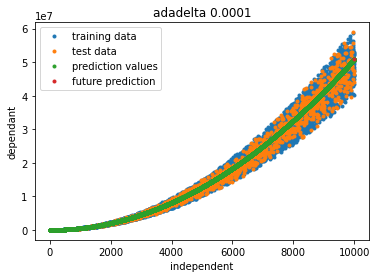

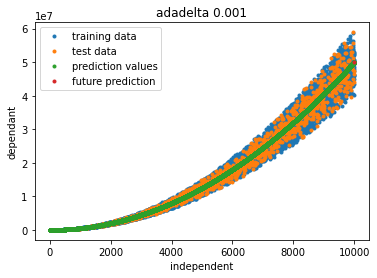

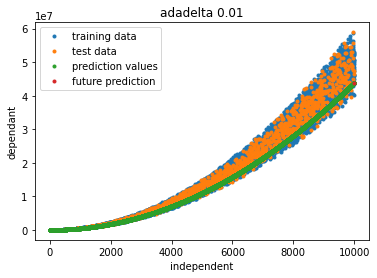

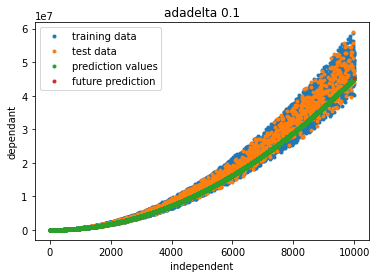

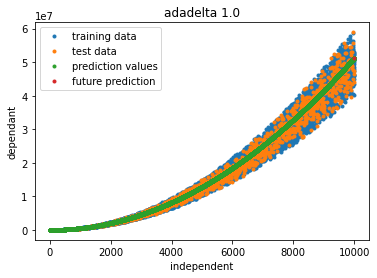

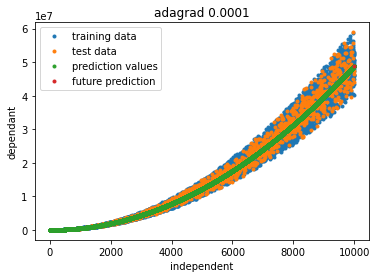

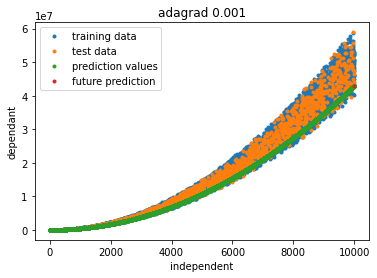

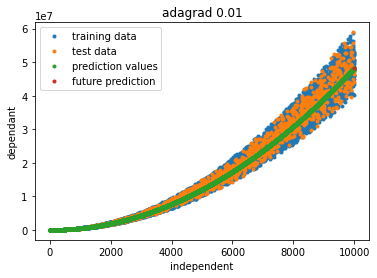

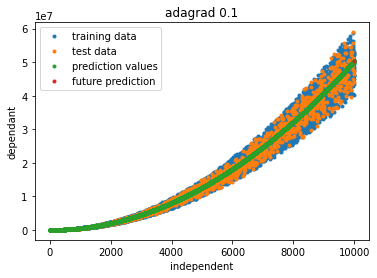

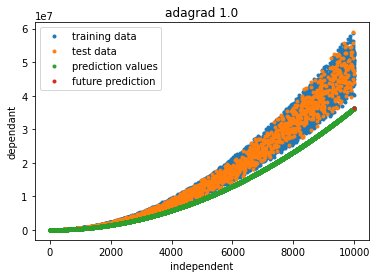

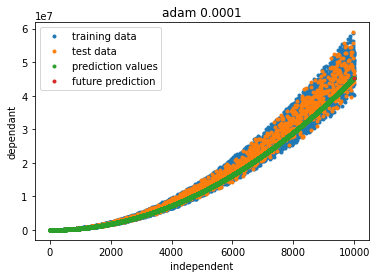

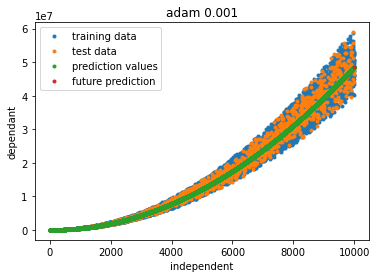

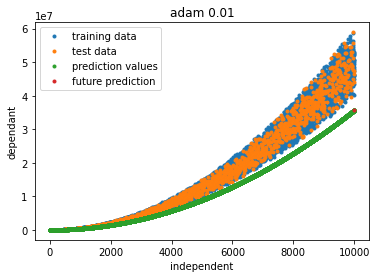

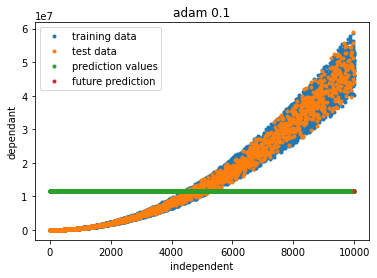

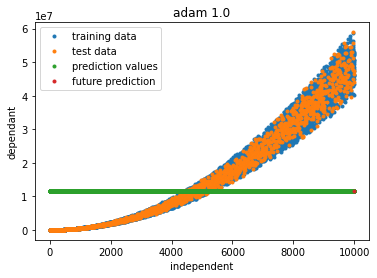

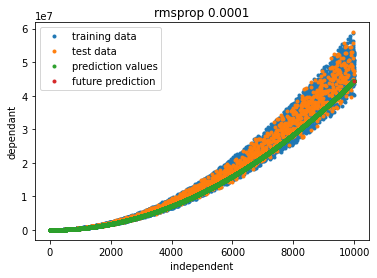

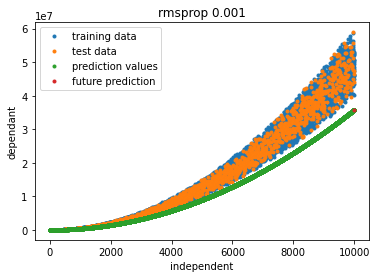

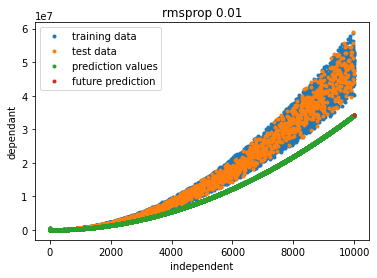

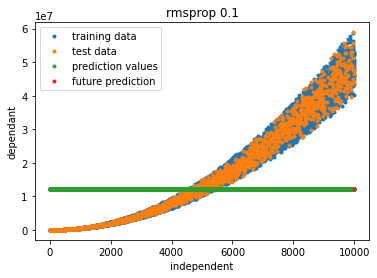

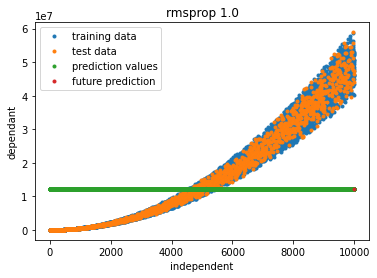

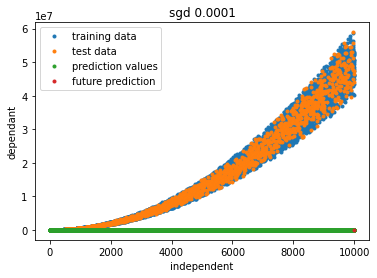

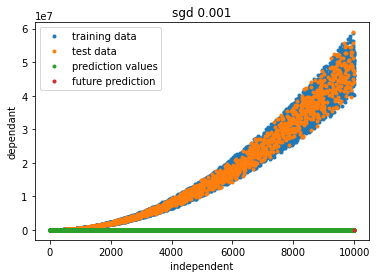

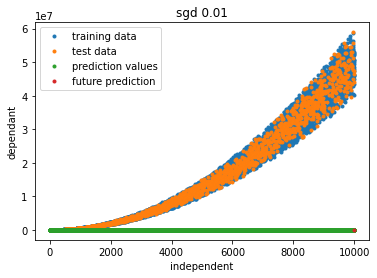

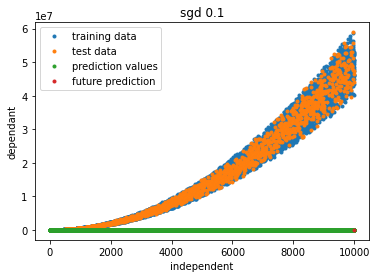

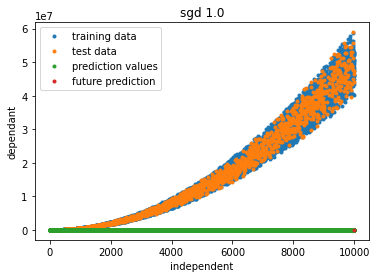

In [3]:

session_num = 0

for optimizerName in HP_OPTIMIZERNAME.domain.values:
    for learningRate in HP_LEARNINGRATE.domain.values:
        hparams = {
            HP_OPTIMIZERNAME: optimizerName,
            HP_LEARNINGRATE: learningRate,
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run('logs/hparam_tuning/' + run_name, hparams)
        session_num += 1

tf.random.set_seed(1234)
np.random.seed(0)